In [1]:
import pandas as pd
import numpy as np
import copy
import treelib
import itertools
import scipy.optimize as opt

In [2]:
class Node:
    def __init__(self,branches=None,attribute=None,threshold=None,value=None):
        if branches is None and value is None:
            print("ERROR")
        
        self.branches = branches
        self.threshold = threshold
        self.attribute = attribute
        self.is_leaf = True if self.branches is None else False
        self.value = value
        self.pinfo = {}
        
    def get_child(self,df):
        if isinstance(df[self.attribute],(int,float,np.number)):
            return self.branches[0] if df[self.attribute] < self.threshold else self.branches[1]
        else:
            return self.branches[0] if df[self.attribute] in self.threshold else self.branches[1]
        

In [3]:
class Tree:
    def __init__(self,root):
        self.root = root
        
    def predict(self,x):
        item = self.root
        while not item.is_leaf:
            item = item.get_child(x)
        return item
    
    def leaf_count(self):
        return self._leaf_count(self.root)
    
    def _leaf_count(self,node):
        if node.is_leaf:
            return 1
        else:
            return np.sum([self._leaf_count(b) for b in node.branches])
    
    def nodes(self):
        return self._nodes(self.root)
    
    def _nodes(self,node):
        if node.is_leaf:
            return [node]
        
        nl = [node]
        for b in node.branches:
            nl += self._nodes(b)
        return nl
    
    def classes(self):
        nodes = self.nodes()
        c = []
        for n in nodes:
            c.append(n.value)
        return np.unique(c).tolist()
    
    def show(self):
        tree_view = treelib.Tree()
        self._show(self.root,tree_view)
        tree_view.show()
        
    def _show(self,node,tree_view,parent=None,prefix=""):
        name = str(hash(node))
        if node.is_leaf:
            text = f"{prefix}{node.value}"
        else:
            if isinstance(node.threshold,(int,float,np.number)):
                text = f"{prefix}{node.attribute}<{node.threshold:.2f}"
            else:
                text = f"{prefix}{node.attribute} in {node.threshold}"
        tree_view.create_node(text,name,parent=parent)
        
        if not node.is_leaf:
            for i, b in enumerate(node.branches):
                p = "True: " if i == 0 else "False:"
                self._show(b,tree_view,parent=name,prefix=p)
    

## Test Node and Tree

In [4]:
l0= Node(value="young")
l1=Node(value="old")
r=Node([l0,l1],"age",18)
t=Tree(r)
print(t.predict({"age":2}).value)

young


In [5]:
print(t.predict({"age":20}).value)

old


In [6]:
t.leaf_count()

2

In [7]:
t.nodes()

### Classification And Regression Tree

In [8]:
class CART:
    def __init__(self,df,y_name,X_names=None,min_leaf_samples=1,min_split_samples=1):
        self.y_name = y_name
        if X_names is None:
            X_names = list(df.columns)
            X_names.remove(self.y_name)
        self.X_names = X_names
        self.df = self._handle_missings(df)
        self.tree = None
        self.splittyness = 1.
        self.leaf_loss_threshold = 1e-12
        
        self.classes = np.unique(df[self.y_name]).tolist()
        
        self.min_leaf_samples = min_leaf_samples
        self.min_split_samples = min_split_samples
        
    def train(self,k=5, plot=True, slack=1.):
        """
        train desicion tree by k-fold cross-validation
        """
        #shuffle dataframe
        df = self.df.sample(frac=1.)
        
        # train tree with full dataset
        self.create_tree()
        pres = self.prune()
        beta = self._beta(pres["alpha"])
        qual_cv = np.zeros((len(beta),k))
        #split df for k-fold cross-validation
        training_sets, test_sets = self._k_fold_split(df,k)
        for i in range(len(training_sets)):
            c = CART(training_sets[i],
                     self.y_name,
                     X_names = self.X_names, 
                     min_leaf_samples=self.min_leaf_samples,
                     min_split_samples=self.min_split_samples)
            c.create_tree()          
            pres = c.prune(test_set=test_sets[i])
            qual = self._qualities(beta,pres)
            qual_cv[:,i] = np.array(qual)
        qual_mean = np.mean(qual_cv, axis=1)
        qual_sd = np.std(qual_cv, axis = 1)
        qual_sd_mean = np.mean(qual_sd)
        import matplotlib.pyplot as plt
        plt.errorbar(beta,qual_mean,yerr=qual_sd)
        
        qual_max = np.nanmax(qual_mean)
        ind_max = np.argmax(qual_mean)
        qual_max_sd = qual_sd[ind_max]
        qual_upper = qual_mean + qual_sd * slack
        ind_best = ind_max
        for i in range(ind_max, len(qual_upper)):
            if qual_mean[i] > qual_max - qual_max_sd * slack:
                ind_best = i
        beta_best = beta[ind_best]
        print(f"beta_best: {beta_best}")
        self.create_tree()
        self.prune(alpha_max=beta_best)
    
    def _beta(self,alpha):
        beta = []
        for i in range(len(alpha)-1):
            if alpha[i] <= 0:
                continue
            b = np.sqrt(alpha[i]*alpha[i+1])
            beta.append(b)
        return beta
            
    def _quality_at(self,b,data):
        for i, a in enumerate(data["alpha"]):
            if a > b:
                return data["A_cv"][i-1]
        return 0.
    
    def _qualities(self,beta,data):
        return [self._quality_at(b,data) for b in beta]
    
    @staticmethod
    def _k_fold_split(df,k):
        N = len(df.index)
        n = int(np.ceil(N/k))
        training_sets = []
        test_sets = []
        for i in range(k):
            test = df.iloc[i*n:min(N,(i+1)*n),:]
            training = df.loc[df.index.difference(test.index),:]
            test_sets.append(test)
            training_sets.append(training)
        return training_sets, test_sets
    
    def _handle_missings(self,df_in):
        df_out = df_in.dropna(subset=[self.y_name])
        # use nan as category
        # use mean if numerical
        for name in self.X_names:
            if np.issubdtype(df_out[name].values.dtype, np.number):
                df_out[name] = df_out[name].fillna(np.nanmean(df_out[name].values))
            else:
                df_out[name] = df_out[name].fillna("missing")
        return df_out
        
    def create_tree(self, leaf_loss_threshold=1e-12):
        self.leaf_loss_threshold = leaf_loss_threshold
        root = self._node_or_leaf(self.df)
        self.tree = Tree(root)
        n_leafs = self.tree.leaf_count()
        print(f"A tree with {n_leafs} leafs was created")
        return self.tree
    
    def _gini_impurity(self, df):
        unique, counts = np.unique(df[self.y_name].values, return_counts=True)
        N = df[self.y_name].values.ravel().size
        p = counts/N
        #print(unique)
        #print(p)
        return 1. - np.sum(p**2)
    
    def _shannon_entropy(self,df):
        unique, counts = np.unique(df[self.y_name].values, return_counts=True)
        N = df[self.y_name].values.size
        p = counts/N
        return -np.sum(p * np.log2(p))
    
    def _misclassification_cost(self,df):
        y = df[self.y_name].values
        unique, counts = np.unique(y, return_counts=True)
        N = y.size
        p = np.max(counts)/N
        return 1. - p
        
    def _opt_fun(self,df,split_name):
        def fun(x):
            split_df = [df[df[split_name]<x],
                        df[df[split_name]>=x]]
            N = len(df.index)
            n = [len(df_.index) for df_ in split_df]
            return n[0]/N * self._loss(split_df[0]) + n[1]/N * self._loss(split_df[1])
        return fun
        
    def _node_or_leaf(self,df):
        loss_parent = self._loss(df)
        if (loss_parent < self.leaf_loss_threshold
            or len(df.index) < self.min_leaf_samples):
            return self._leaf(df)
        
        loss_best, split_df, split_threshold, split_name = self._loss_best(df)
        #print(f"Computed split:\nloss: {loss_best:.2f} (parent: {loss_parent:.2f})\nattribute: {split_name}\nthreshold: {split_threshold}\ncount: {[len(df_.index) for df_ in split_df]}")
        if loss_best < loss_parent:
            #print(f"=> Node({split_name}, {split_threshold})")
            branches = []
            for i in range(2):
                branches.append(self._node_or_leaf(split_df[i]))
            unique, counts = np.unique(df[self.y_name], return_counts=True)
            value = unique[np.argmax(counts)]
            item = Node(branches=branches,attribute=split_name,threshold=split_threshold,value=value)
            item.pinfo["N"] = len(df.index)
            item.pinfo["r"] = self._misclassification_cost(df)
            item.pinfo["R"] = item.pinfo["N"]/len(self.df.index) * item.pinfo["r"]
        else:
            item = self._leaf(df)
            
        return item
    
    def _leaf(self,df):
        unique, counts = np.unique(df[self.y_name].values,return_counts=True)
        #print([(unique[i], counts[i]) for i in range(len(counts))])
        sort_ind = np.argsort(-counts)
        value = unique[sort_ind[0]]
        leaf = Node(value=value)
        
        leaf.pinfo["N"] = len(df.index)
        leaf.pinfo["r"] = self._misclassification_cost(df)
        leaf.pinfo["R"] = leaf.pinfo["N"]/len(self.df.index) * leaf.pinfo["r"]
        #print(f"=> Leaf({value}, N={len(df.index)})")
        return leaf
    
    def _loss_best(self,df):
        loss = np.Inf
        split_df = None
        split_threshold = None
        split_name = None
        for name in self.X_names:
            loss_ = np.Inf
            if np.issubdtype(df[name].values.dtype, np.number):
                loss_, split_df_, split_threshold_ = self._split_by_number(df,name)
            else:
                loss_, split_df_, split_threshold_ = self._split_by_class(df,name)
            if (loss_ < loss
                and np.min([len(df_.index) for df_ in split_df_]) >= self.min_split_samples):
                loss = loss_
                split_threshold = split_threshold_
                split_df = split_df_
                split_name = name

        return loss, split_df, split_threshold, split_name
    
    def _split_by_number(self,df,name):
        res = opt.minimize_scalar(self._opt_fun(df,name),bounds=(df[name].min(),df[name].max()),method="bounded")
        split_threshold = res.x
        split_df = [df[df[name]<split_threshold],
                    df[df[name]>=split_threshold]]
        loss = res.fun
        return loss, split_df, split_threshold
    
    def _split_by_class(self,df,name):
        unique = np.unique(df[name])
        comb = []
        for i in range(1,len(unique)):
            comb += list(itertools.combinations(unique,i))
            
        if len(comb) < 1:
            return np.Inf, None, None
        
        loss_ = np.Inf
        loss = np.Inf
        for c in comb:
            split_threshold_ = c
            split_df_ =[df[df[name].isin(split_threshold_)],
                        df[~df[name].isin(split_threshold_)]]
            N = len(df.index)
            n = [len(df_.index) for df_ in split_df_]
            loss_ = n[0]/N * self._loss(split_df_[0]) + n[1]/N * self._loss(split_df_[1])
            if loss_ < loss:
                loss = loss_
                split_threshold = split_threshold_
                split_df = split_df_
        return loss, split_df, split_threshold
    
    def _loss(self,df):
        #return self._gini_impurity(df)
        return self._shannon_entropy(df)
    
    def metrics(self,df=None):
        confmat = self.confusion_matrix(df=df)
        P = self._precision(confmat)
        #print(f"precision: {P}")
        R = self._recall(confmat)
        #print(f"recall: {R}")
        F = np.mean(self._F1(P,R))
        #print(f"F-score: {F}")
        A = self._accuracy(confmat)
        return {"precision":P,
                "recall":R,
                "F-score":F,
                "accuracy":A}
    
    def prune(self,alpha_max=None, test_set=None):
        #if not alpha_max:
        #    tree = copy.deepcopy(self.tree)
        #else:
        tree = self.tree
                
        d={}
        d["alpha"]=[]
        d["R"]=[]
        d["n_leafs"]=[]
        if test_set is not None:
            d["A_cv"] = []
            d["R_cv"] = []
            d["P_cv"] = []
            d["F_cv"] = []
        n_iter = 0
        g_min = 0
        alpha = 0
        #print("n_leafs\tR\talpha")
        n_leafs, R = self._g2(tree.root)
        #print(f"{n_leafs}\t{R:.4f}\t{g_min:.2e}")
        while tree.leaf_count() > 1 and n_iter < 100:
            n_iter += 1
            
            alpha = g_min
            if alpha_max is not None and alpha > alpha_max:
                break
            # compute g
            nodes = tree.nodes()
            g = []
            pnodes = []
            for n in nodes:
                if not n.is_leaf:
                    g.append(self._g(n))
                    pnodes.append(n)
                    
            g_min = max(0,np.min(g))
            for i, n in enumerate(pnodes):
                if g[i] <= g_min:
                    n.is_leaf = True
            N, R = self._g2(tree.root)
            #print(f"{N}\t{R:.4f}\t{alpha:.2e}")
            if test_set is not None:
                metrics = self.metrics(df=test_set)
                d["A_cv"].append(metrics["accuracy"])
                d["R_cv"].append(metrics["recall"])
                d["P_cv"].append(metrics["precision"])
                d["F_cv"].append(metrics["F-score"])
            d["alpha"].append(alpha)
            d["n_leafs"].append(N)
            d["R"].append(R)
        return d
            
    
    def _g(self,node):
        n_leafs, R_desc = self._g2(node)
        R = node.pinfo["R"]
        #print(n_leafs, R, R_desc)
        return (R - R_desc)/(n_leafs - 1)
                              
    def _g2(self,node):
        n_leafs = 0
        R_desc = 0
        if node.is_leaf:
            return 1, node.pinfo["R"]
        
        for b in node.branches:
            nl, R = self._g2(b)
            n_leafs += nl
            R_desc += R
        return n_leafs, R_desc
    
    def confusion_matrix(self,df=None):
        if df is None:
            df = self.df
        unique = np.unique(self.df[self.y_name].values)
        classes = unique.tolist()#self.tree.classes()
        n_classes = len(classes)
        confmat = np.zeros((n_classes,n_classes))
        
        for i in range(len(df.index)):
            val_pred = self.tree.predict(df.iloc[i]).value
            val_true = df[self.y_name].iloc[i]
            i_pred = classes.index(val_pred)
            i_true = classes.index(val_true)
            confmat[i_true,i_pred] += 1
        return confmat
           
    @staticmethod
    def _precision(m):
        return np.diag(m) / np.sum(m, axis=1)
        
    @staticmethod
    def _recall(m):
        return np.diag(m) / np.sum(m, axis=0)
    
    @staticmethod
    def _F1(P,R):
        #F = np.zeros_like(P)
        #for i in range(len(
        return 2 * P * R / (P + R)
    
    @staticmethod
    def _accuracy(m):
        return np.sum(np.diag(m))/np.sum(np.sum(m))
        

Iris dataset
==

In [9]:
df_iris=pd.read_csv("iris.csv")

In [10]:
df_iris.columns
X_names=["petal_length","petal_width"]
df_iris[X_names]

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


In [11]:
c_iris = CART(df_iris,"species")#_names)
c_iris.create_tree()


A tree with 11 leafs was created


In [12]:
c_iris.tree.predict(df_iris.iloc[0]).value

'setosa'

In [13]:
c_iris.tree.root.branches[0].pinfo


{'N': 50, 'r': 0.0, 'R': 0.0}

In [14]:
c_iris.prune()


{'alpha': [0,
  0.0033333333333333305,
  0.006666666666666663,
  0.29333333333333333],
 'R': [0.013333333333333322,
  0.03999999999999997,
  0.3333333333333333,
  0.6666666666666667],
 'n_leafs': [7, 3, 2, 1]}

In [15]:
c_iris.create_tree()
c_iris.prune(alpha_max = 2e-3)


A tree with 11 leafs was created


{'alpha': [0], 'R': [0.013333333333333322], 'n_leafs': [7]}

In [16]:

c_iris.confusion_matrix()


array([[50.,  0.,  0.],
       [ 0., 48.,  2.],
       [ 0.,  0., 50.]])

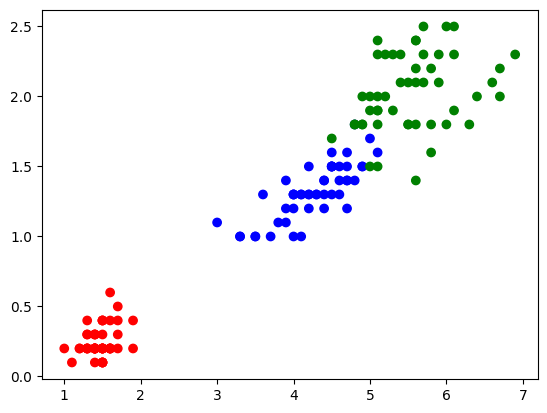

In [17]:
import matplotlib.pyplot as plt
colors = {"setosa":"red", "versicolor":"blue", "virginica":"green"}
plt.scatter(df_iris["petal_length"],df_iris["petal_width"],c=df_iris["species"].map(colors))


In [18]:

x, y = np.meshgrid(np.linspace(1,7,11),np.linspace(0,2.5,11))
col = []
for i in range(len(x.ravel())):
    d = df_iris.iloc[120].copy()
    d["petal_length"] = x.ravel()[i]
    d["petal_width"] = y.ravel()[i]
    col.append(c_iris.tree.predict(d).value)
for i in range(len(col)):
    if col[i] == "setosa":
        col[i] = 0
    if col[i] == "versicolor":
        col[i] = 1
    if col[i] == "virginica":
        col[i] = 2
z = np.array(col).reshape(x.shape)

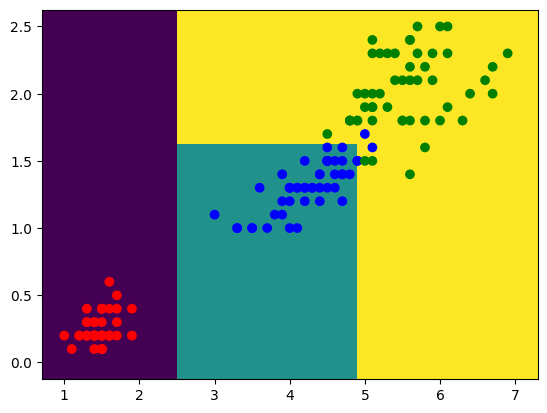

In [19]:
fig, ax = plt.subplots()
ax.pcolormesh(x,y,z)
ax.scatter(df_iris["petal_length"],df_iris["petal_width"],c=df_iris["species"].map(colors))

In [20]:
c_iris.metrics()

{'precision': array([1.  , 0.96, 1.  ]),
 'recall': array([1.        , 1.        , 0.96153846]),
 'F-score': 0.9866613311991462,
 'accuracy': 0.9866666666666667}

A tree with 11 leafs was created
A tree with 7 leafs was created


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in true_divide


A tree with 11 leafs was created
A tree with 10 leafs was created
A tree with 9 leafs was created
A tree with 8 leafs was created
beta_best: 0.004714045207910313
A tree with 11 leafs was created


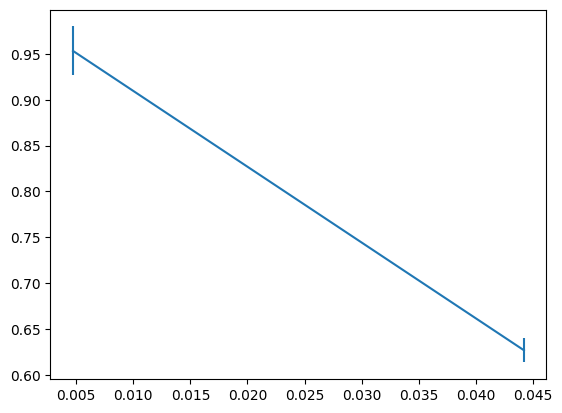

In [21]:
c_iris.train()

In [22]:
c_iris.tree.show()

petal_length<2.30
├── False:petal_width<1.65
│   ├── False:virginica
│   └── True: versicolor
└── True: setosa



In [23]:
c_iris.metrics()

{'precision': array([1.  , 0.96, 0.92]),
 'recall': array([1.        , 0.92307692, 0.95833333]),
 'F-score': 0.9599839935974389,
 'accuracy': 0.96}

# Titanic dataset

In [24]:
df_titanic = pd.read_csv("titanic.csv")
df_titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [25]:
df_titanic.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [26]:

c_titanic = CART(df_titanic,"Survived",["Pclass","Age","Fare","Siblings/Spouses Aboard","Sex","Parents/Children Aboard"], min_leaf_samples=5, min_split_samples=4)
c_titanic.create_tree()

A tree with 96 leafs was created


In [27]:

c_titanic.metrics()

{'precision': array([0.95412844, 0.76315789]),
 'recall': array([0.86522463, 0.91258741]),
 'F-score': 0.869357277042274,
 'accuracy': 0.8804960541149943}

In [28]:
c_titanic.prune()


{'alpha': [0,
  0,
  4.336808689942018e-19,
  6.505213034913027e-19,
  8.673617379884035e-19,
  1.0842021724855044e-18,
  1.3877787807814458e-18,
  4.336808689942018e-18,
  6.938893903907228e-18,
  0.0005636978579481406,
  0.0006764374295377678,
  0.0011273957158962787,
  0.0011273957158962791,
  0.00112739571589628,
  0.0016910935738444245,
  0.002254791431792559,
  0.0024426907177752706,
  0.002442690717775272,
  0.00479143179255918,
  0.007891770011273967,
  0.01071025930101465],
 'R': [0.11950394588500562,
  0.11950394588500562,
  0.11950394588500562,
  0.11950394588500562,
  0.11950394588500564,
  0.11950394588500564,
  0.11950394588500564,
  0.11950394588500565,
  0.12063134160090193,
  0.12401352874859076,
  0.1262683201803833,
  0.1273957158962796,
  0.1285231116121759,
  0.13190529875986473,
  0.13641488162344984,
  0.15107102593010147,
  0.1657271702367531,
  0.18489289740698983,
  0.1927846674182638,
  0.2142051860202931,
  0.38556933483652767],
 'n_leafs': [51,
  50,
  47,


In [29]:
c_titanic.create_tree()
c_titanic.prune(alpha_max=1.7e-3)


A tree with 96 leafs was created


{'alpha': [0,
  0,
  4.336808689942018e-19,
  6.505213034913027e-19,
  8.673617379884035e-19,
  1.0842021724855044e-18,
  1.3877787807814458e-18,
  4.336808689942018e-18,
  6.938893903907228e-18,
  0.0005636978579481406,
  0.0006764374295377678,
  0.0011273957158962787,
  0.0011273957158962791,
  0.00112739571589628,
  0.0016910935738444245],
 'R': [0.11950394588500562,
  0.11950394588500562,
  0.11950394588500562,
  0.11950394588500562,
  0.11950394588500564,
  0.11950394588500564,
  0.11950394588500564,
  0.11950394588500565,
  0.12063134160090193,
  0.12401352874859076,
  0.1262683201803833,
  0.1273957158962796,
  0.1285231116121759,
  0.13190529875986473,
  0.13641488162344984],
 'n_leafs': [51, 50, 47, 44, 43, 38, 37, 36, 34, 29, 27, 26, 25, 23, 21]}

In [30]:
c_titanic.tree.show()

Sex in ('female',)
├── False:Pclass<1.47
│   ├── False:Age<45.02
│   │   ├── False:0
│   │   └── True: Age<10.37
│   │       ├── False:0
│   │       └── True: Siblings/Spouses Aboard<1.17
│   │           ├── False:0
│   │           └── True: 1
│   └── True: Age<52.46
│       ├── False:0
│       └── True: Parents/Children Aboard<1.24
│           ├── False:1
│           └── True: Age<36.25
│               ├── False:0
│               └── True: Age<22.25
│                   ├── False:Age<27.24
│                   │   ├── False:Age<31.06
│                   │   │   ├── False:1
│                   │   │   └── True: 0
│                   │   └── True: 1
│                   └── True: 0
└── True: Pclass<2.24
    ├── False:Fare<24.67
    │   ├── False:0
    │   └── True: Age<37.99
    │       ├── False:0
    │       └── True: Parents/Children Aboard<1.53
    │           ├── False:1
    │           └── True: Age<6.04
    │               ├── False:Age<32.32
    │               │   ├── False:1
    

In [31]:
c_titanic.metrics()


{'precision': array([0.93577982, 0.74853801]),
 'recall': array([0.8557047 , 0.87972509]),
 'F-score': 0.851399717273587,
 'accuracy': 0.8635851183765502}

A tree with 96 leafs was created
A tree with 82 leafs was created


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in true_divide


A tree with 63 leafs was created
A tree with 86 leafs was created
A tree with 77 leafs was created
A tree with 83 leafs was created
beta_best: 0.002442690717775271
A tree with 96 leafs was created


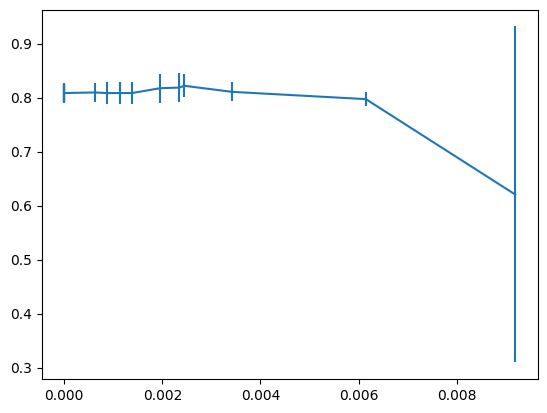

In [32]:
c_titanic.train(slack=0.1)


In [33]:
c_titanic.tree.show()

Sex in ('female',)
├── False:Pclass<1.47
│   ├── False:Age<45.02
│   │   ├── False:0
│   │   └── True: Age<10.37
│   │       ├── False:0
│   │       └── True: Siblings/Spouses Aboard<1.17
│   │           ├── False:0
│   │           └── True: 1
│   └── True: 0
└── True: Pclass<2.24
    ├── False:Fare<24.67
    │   ├── False:0
    │   └── True: Age<37.99
    │       ├── False:0
    │       └── True: 1
    └── True: 1



In [34]:
c_titanic.metrics()

{'precision': array([0.90458716, 0.72222222]),
 'recall': array([0.83843537, 0.82608696]),
 'F-score': 0.8204633922338358,
 'accuracy': 0.8342728297632469}

# Penguins dataset

In [35]:

df_penguins = pd.read_csv("penguins.txt")
df_penguins.columns

Index(['rowid', 'species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')

In [36]:
df_penguins

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...,...
339,340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,343,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [37]:
c_penguins = CART(df_penguins,"species",["island","bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g","sex"])

In [38]:
c_penguins.create_tree()

A tree with 13 leafs was created


In [39]:
c_penguins.metrics()

{'precision': array([1., 1., 1.]),
 'recall': array([1., 1., 1.]),
 'F-score': 1.0,
 'accuracy': 1.0}

In [40]:
c_penguins.prune()


{'alpha': [0,
  0.002906976744186047,
  0.0029069767441860478,
  0.004844961240310083,
  0.00872093023255814,
  0.01162790697674419,
  0.023255813953488393,
  0.14244186046511625],
 'R': [0.005813953488372094,
  0.01162790697674419,
  0.026162790697674437,
  0.03488372093023258,
  0.04651162790697677,
  0.06976744186046516,
  0.21220930232558144,
  0.5581395348837209],
 'n_leafs': [11, 9, 6, 5, 4, 3, 2, 1]}

In [41]:
c_penguins.create_tree()
c_penguins.prune(alpha_max=5e-3)

A tree with 13 leafs was created


{'alpha': [0,
  0.002906976744186047,
  0.0029069767441860478,
  0.004844961240310083],
 'R': [0.005813953488372094,
  0.01162790697674419,
  0.026162790697674437,
  0.03488372093023258],
 'n_leafs': [11, 9, 6, 5]}

A tree with 13 leafs was created
A tree with 12 leafs was created


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in true_divide


A tree with 13 leafs was created
A tree with 13 leafs was created
A tree with 9 leafs was created
A tree with 11 leafs was created
beta_best: 0.010070062834702777
A tree with 13 leafs was created


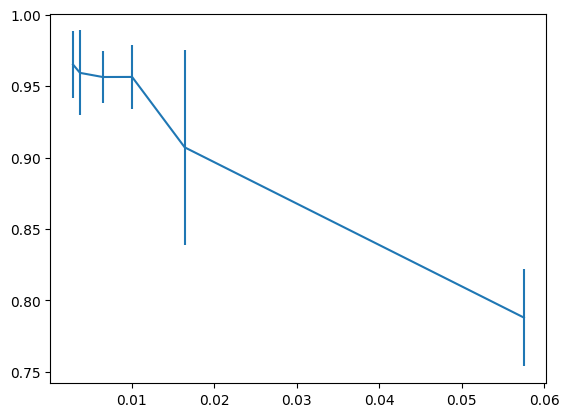

In [42]:
c_penguins.train()

In [43]:
c_penguins.tree.show()

flipper_length_mm<204.36
├── False:island in ('Biscoe',)
│   ├── False:Chinstrap
│   └── True: Gentoo
└── True: bill_length_mm<43.68
    ├── False:Chinstrap
    └── True: Adelie



In [44]:
c_penguins.metrics()

{'precision': array([0.94736842, 0.91176471, 0.98387097]),
 'recall': array([0.96      , 0.86111111, 1.        ]),
 'F-score': 0.9437421961731443,
 'accuracy': 0.9534883720930233}